<a href="https://colab.research.google.com/github/p4triko/Microtransaction-Prediction-IDS25/blob/rander/Project_B10_Predict_Microtransaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial imports

In [1]:
# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for model training
from sklearn.model_selection import train_test_split

### Loading in the dataset, two options are available. Chooose ONE: either the GitHub URL, if that fails, upload the data manually by downloading the csv file from the repository.

In [2]:

url = 'https://raw.githubusercontent.com/p4triko/Microtransaction-Prediction-IDS25/refs/heads/main/online_gaming_behavior_dataset.csv'

try:
  df = pd.read_csv(url)
  print("Data loaded from GitHub")
except Exception as e:
  print("Github loading failed: ", e)
  print("Trying manual upload")
  from google.colab import files
  uploaded = files.upload()
  name = list(uploaded.keys())[0]
  df = pd.read_csv(name)
  print(f"Loaded data from the file: {name}")

Data loaded from GitHub


### Initial inspections, ensure everything was properly loaded

In [3]:
df.shape

(40034, 13)

In [4]:
df.head(10)

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
5,9005,37,Male,Europe,RPG,20.561855,0,Easy,2,81,74,22,Low
6,9006,25,Male,USA,Action,9.752716,0,Hard,1,50,13,2,Low
7,9007,25,Female,Asia,RPG,4.401729,0,Medium,10,48,27,23,Medium
8,9008,38,Female,Europe,Simulation,18.152733,0,Easy,5,101,23,41,Medium
9,9009,38,Female,Other,Sports,23.942772,0,Easy,13,95,99,36,High


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

### Before cleaning let's check the target distribution

In [6]:
target_column = "InGamePurchases"
df[target_column].value_counts(normalize=True)

,proportion
InGamePurchases,
0,0.799146
1,0.200854


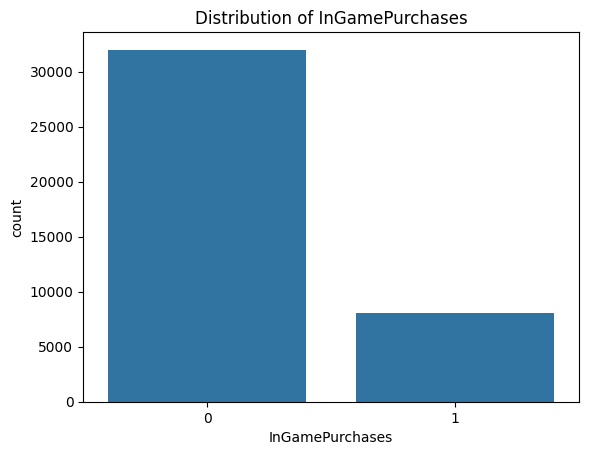

In [7]:
sns.countplot(x=target_column, data=df)
plt.title(f"Distribution of {target_column}")
plt.show()

###Data cleaning and preparation

In [8]:
# Drop PlayerID column, as it offers no predictive value.
if 'PlayerID' in df.columns:
  df = df.drop(columns=["PlayerID"])

# Convert AvgSessionDurationMinutes to hours for better interpretability
if 'AvgSessionDurationMinutes' in df.columns:
  df['AvgSessionDurationHours'] = df['AvgSessionDurationMinutes'] / 60
  df = df.drop(columns=["AvgSessionDurationMinutes"])

# Let's check if there are any missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Age                        0
Gender                     0
Location                   0
GameGenre                  0
PlayTimeHours              0
InGamePurchases            0
GameDifficulty             0
SessionsPerWeek            0
PlayerLevel                0
AchievementsUnlocked       0
EngagementLevel            0
AvgSessionDurationHours    0
dtype: int64


In [9]:
# Get rid of logically impossible values, such as:
# SessionsPerWeek should be at least 1.
# PlayTimeHours is more realistic, shouldn't be almost 24 hours.
if "SessionsPerWeek" in df.columns:
  before = len(df)
  df = df[df["SessionsPerWeek"] >= 1]
  print(f"SessionsPerWeek cleaned, {before - len(df)} rows with a value of 0.")

if "PlayTimeHours" in df.columns:
  before = len(df)
  df = df[df["PlayTimeHours"] <= 15]
  print(f"PlayTimeHours cleaned, {before - len(df)} rows with an unrealistic playtime.")

SessionsPerWeek cleaned, 1967 rows with a value of 0.
PlayTimeHours cleaned, 14322 rows with an unrealistic playtime.


In [10]:
df.head(10)

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,PlayerLevel,AchievementsUnlocked,EngagementLevel,AvgSessionDurationHours
1,29,Female,USA,Strategy,5.525961,0,Medium,5,11,10,Medium,2.400000
2,22,Female,USA,Sports,8.223755,0,Easy,16,35,41,High,2.366667
3,35,Male,USA,Action,5.265351,1,Easy,9,57,47,Medium,1.416667
6,25,Male,USA,Action,9.752716,0,Hard,1,13,2,Low,0.833333
7,25,Female,Asia,RPG,4.401729,0,Medium,10,27,23,Medium,0.800000
10,17,Male,USA,Strategy,4.829916,0,Hard,8,14,12,High,1.583333
11,36,Female,Asia,Simulation,5.535981,1,Easy,16,62,31,High,2.066667
15,16,Male,Europe,RPG,7.951511,0,Medium,10,58,24,High,2.600000
20,39,Female,USA,Sports,1.722581,0,Easy,2,34,37,Medium,2.950000
22,42,Male,USA,Sports,10.448126,0,Medium,2,81,5,Low,2.000000


In [11]:
df.shape

(23745, 12)

### Check target distribution after cleaning

In [12]:
df[target_column].value_counts(normalize=True)

,proportion
InGamePurchases,
0,0.795999
1,0.204001


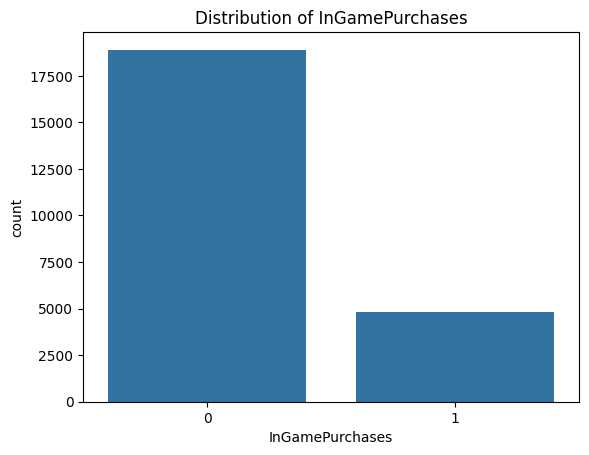

In [13]:
sns.countplot(x=target_column, data=df)
plt.title(f"Distribution of {target_column}")
plt.show()

## Identify and Encode Categorical Features

Our dataset contains quite many categorical features, so we need to identify them in the DataFrame and apply one-hot encoding to convert them into a
numerical format suitable for machine learning models. The original categorical columns will be dropped.


In [14]:
categorical_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical columns identified: {list(categorical_cols)}")

# Apply one-hot encoding and drop original columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("DataFrame after one-hot encoding:")
print(df.head())

Categorical columns identified: ['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel']
DataFrame after one-hot encoding:
   Age  PlayTimeHours  InGamePurchases  SessionsPerWeek  PlayerLevel  \
1   29       5.525961                0                5           11   
2   22       8.223755                0               16           35   
3   35       5.265351                1                9           57   
6   25       9.752716                0                1           13   
7   25       4.401729                0               10           27   

   AchievementsUnlocked  AvgSessionDurationHours  Gender_Male  \
1                    10                 2.400000        False   
2                    41                 2.366667        False   
3                    47                 1.416667         True   
6                     2                 0.833333         True   
7                    23                 0.800000        False   

   Location_Europe  Location_Other  L

### One more quick look at the data to validate the encoding.

In [15]:
df.head(15)

,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,PlayerLevel,AchievementsUnlocked,AvgSessionDurationHours,Gender_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,EngagementLevel_Low,EngagementLevel_Medium
1,29,5.525961,0,5,11,10,2.400000,False,False,False,True,False,False,False,True,False,True,False,True
2,22,8.223755,0,16,35,41,2.366667,False,False,False,True,False,False,True,False,False,False,False,False
3,35,5.265351,1,9,57,47,1.416667,True,False,False,True,False,False,False,False,False,False,False,True
6,25,9.752716,0,1,13,2,0.833333,True,False,False,True,False,False,False,False,True,False,True,False
7,25,4.401729,0,10,27,23,0.800000,False,False,False,False,True,False,False,False,False,True,False,True
10,17,4.829916,0,8,14,12,1.583333,True,False,False,True,False,False,False,True,True,False,False,False
11,36,5.535981,1,16,62,31,2.066667,False,False,False,False,False,True,False,False,False,False,False,False
15,16,7.951511,0,10,58,24,2.600000,True,True,False,False,True,False,False,False,False,True,False,False
20,39,1.722581,0,2,34,37,2.950000,False,False,False,True,False,False,True,False,False,False,False,True
22,42,10.448126,0,2,81,5,2.000000,True,False,False,True,False,False,True,False,False,True,True,False


Now we need to change the boolean values into either 1's or 0's for the machine learning algorithm.

In [16]:
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

print("DataFrame after converting boolean columns to 0s and 1s:")
df.head(15)

DataFrame after converting boolean columns to 0s and 1s:


,Age,PlayTimeHours,InGamePurchases,SessionsPerWeek,PlayerLevel,AchievementsUnlocked,AvgSessionDurationHours,Gender_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,EngagementLevel_Low,EngagementLevel_Medium
1,29,5.525961,0,5,11,10,2.400000,0,0,0,1,0,0,0,1,0,1,0,1
2,22,8.223755,0,16,35,41,2.366667,0,0,0,1,0,0,1,0,0,0,0,0
3,35,5.265351,1,9,57,47,1.416667,1,0,0,1,0,0,0,0,0,0,0,1
6,25,9.752716,0,1,13,2,0.833333,1,0,0,1,0,0,0,0,1,0,1,0
7,25,4.401729,0,10,27,23,0.800000,0,0,0,0,1,0,0,0,0,1,0,1
10,17,4.829916,0,8,14,12,1.583333,1,0,0,1,0,0,0,1,1,0,0,0
11,36,5.535981,1,16,62,31,2.066667,0,0,0,0,0,1,0,0,0,0,0,0
15,16,7.951511,0,10,58,24,2.600000,1,1,0,0,1,0,0,0,0,1,0,0
20,39,1.722581,0,2,34,37,2.950000,0,0,0,1,0,0,1,0,0,0,0,1
22,42,10.448126,0,2,81,5,2.000000,1,0,0,1,0,0,1,0,0,1,1,0


#Next we seperate the target column from the features and split the data into training and testing sets.

In [17]:
# Separate features (X) and target (y)
X = df.drop(columns=[target_column])
y = df[target_column]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"y_train distribution before undersampling:\n{y_train.value_counts(normalize=True)}")

Shape of X: (23745, 18)
Shape of y: (23745,)
y_train distribution before undersampling:
InGamePurchases
0    0.79601
1    0.20399
Name: proportion, dtype: float64


# Imbalance in the target value

1.   List item
2.   List item



Right now we face an issue that the target value is very unbalanced, almost a
80/20 ratio, meaning one class is significantly more represented than the other. Before training the model we definitely need allevitate this problem. <br>
<br>
The possible solutions are:

*   Undersampling: Reduces the number of samples in the majority class to balance the dataset. This can result in a loss of insight, but since we have so many entries in the target column, it can work.
*   Oversampling: We can use a technique like SMOTE(Synthetic Minority Over-sampling Technique), which creates new synthetic observations of the minority class.

## Creating a function to evaluate and save the results of models
This function is just a helper method, to quickly evaluate given functions and save their data.

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

results = []   # store all models here


def evaluate_model(name, model, X_train, y_train, X_test, y_test, threshold=None):

    # If threshold is None:
    # use model.predict(X_test)  (normal behaviour, threshold = 0.5)
    # If threshold is given (e.g. 0.3):
    # use model.predict_proba(X_test) and apply the custom threshold
    # on the probability of class 1.

    # Train
    model.fit(X_train, y_train)

    # Predictions
    if threshold is None:
        # standard 0.5 threshold inside predict()
        y_pred = model.predict(X_test)
        thr_value = 0.5
    else:
        # manual threshold on P(class=1)
        if not hasattr(model, "predict_proba"):
            raise ValueError("Model does not support predict_proba, cannot use custom threshold.")
        proba_1 = model.predict_proba(X_test)[:, 1]
        y_pred = (proba_1 >= threshold).astype(int)
        thr_value = float(threshold)

    # Per-class metrics
    prec0, rec0, f10, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[0], average=None
    )
    prec1, rec1, f11, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average=None
    )

    # Convert to plain floats
    prec0 = float(prec0[0])
    rec0  = float(rec0[0])
    f10   = float(f10[0])

    prec1 = float(prec1[0])
    rec1  = float(rec1[0])
    f11   = float(f11[0])

    # Macro F1
    macro_f1 = (f10 + f11) / 2

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Save summary results (now also store threshold)
    results.append({
        "Model": name,
        "Threshold": thr_value,
        "Accuracy": acc,
        "Precision_0": prec0,
        "Recall_0": rec0,
        "F1_0": f10,
        "Precision_1": prec1,
        "Recall_1": rec1,
        "F1_1": f11,
        "Macro_F1": macro_f1
    })

    # Print nicely
    print(f"\n=== {name} Results (threshold = {thr_value:.2f}) ===")
    print(f"Accuracy: {acc:.4f}\n")
    print("Class 0 (majority):")
    print(f"  Precision: {prec0:.4f}")
    print(f"  Recall:    {rec0:.4f}")
    print(f"  F1-score:  {f10:.4f}\n")
    print("Class 1 (minority):")
    print(f"  Precision: {prec1:.4f}")
    print(f"  Recall:    {rec1:.4f}")
    print(f"  F1-score:  {f11:.4f}\n")
    print(f"Macro F1: {macro_f1:.4f}")


# Balanced Random Forest

Using a **Balanced Random Forest** is a good first attempt, not because it's perfect, but because it solves several imbalance problems automatically and safely.

We use the balanced version of the Random Forest to avoid our decision trees becoming biased towards the majority class. Since our dataset is split around 80/20, the splits will mostly optimize for class 0 (not buying microtransactions) and leave class 1 (buying microtransactions) very weak.  
Balanced RF solves this issue by selecting all of the minority samples and an equal amount of randomly chosen majority samples for each tree.

We keep the hyperparameters simple and focused on controlling model complexity:

- **`n_estimators = 300`**  
  We use many trees so that individual random variations average out. This makes the predictions more stable, especially for the minority class.

- **`max_depth = 10`**  
  We limit the depth of each tree so they cannot perfectly memorize the training data. This helps avoid overfitting and forces the model to learn patterns that generalise better to new players.

- **`min_samples_leaf = 10`**  
  Each leaf must contain at least 10 training samples. This prevents extremely small leaves that would base decisions on just a handful of players and would be very noisy, which is especially important with an imbalanced dataset.

Overall, these settings give us a Balanced Random Forest that is expressive enough to find useful patterns, but still regularised so it does not simply overfit the majority class.




## Balanced Random Forest with the default threshold (0.5).

In [19]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc_default = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf = 10,
    random_state=42,
    n_jobs =-1
  )
evaluate_model("Balanced Random Forest", brfc_default, X_train, y_train, X_test, y_test)


=== Balanced Random Forest Results (threshold = 0.50) ===
Accuracy: 0.6149

Class 0 (majority):
  Precision: 0.7934
  Recall:    0.6979
  F1-score:  0.7426

Class 1 (minority):
  Precision: 0.1980
  Recall:    0.2910
  F1-score:  0.2357

Macro F1: 0.4891


### Default threshold: 0.50

With a threshold of **0.50**, **80% of flagged non-buyers are actual non-buyers** and **we catch 70% of all non-buyers**.  
This means that when the model says *“this player will not buy,”* it is usually right and it covers most of that group.

However, we only **accurately predict 20% of buyers** and **catch only 30% of the total buyers**.  
This means most real spenders never make it onto our targeting list and we leave a large share of potential microtransaction revenue untapped.



## Balanced Random Forest with custom thresholds

In [20]:
from imblearn.ensemble import BalancedRandomForestClassifier

brfc = BalancedRandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf = 10,
    random_state=42,
    n_jobs =-1
  )

for thr in [0.49, 0.48, 0.47, 0.46]:
  evaluate_model("Balanced Random Forest", brfc, X_train, y_train, X_test, y_test, threshold=thr)


=== Balanced Random Forest Results (threshold = 0.48) ===
Accuracy: 0.4361

Class 0 (majority):
  Precision: 0.7943
  Recall:    0.3934
  F1-score:  0.5262

Class 1 (minority):
  Precision: 0.2030
  Recall:    0.6027
  F1-score:  0.3037

Macro F1: 0.4149

=== Balanced Random Forest Results (threshold = 0.47) ===
Accuracy: 0.3578

Class 0 (majority):
  Precision: 0.7972
  Recall:    0.2590
  F1-score:  0.3910

Class 1 (minority):
  Precision: 0.2045
  Recall:    0.7430
  F1-score:  0.3207

Macro F1: 0.3558

=== Balanced Random Forest Results (threshold = 0.46) ===
Accuracy: 0.2965

Class 0 (majority):
  Precision: 0.8079
  Recall:    0.1524
  F1-score:  0.2564

Class 1 (minority):
  Precision: 0.2061
  Recall:    0.8586
  F1-score:  0.3325

Macro F1: 0.2944


### Tuned threshold: 0.47

With a threshold of **0.47** we deliberately relax the filter for buyers.  
We still have only about a **20% “hit rate” among the people flagged as buyers**, but now we **catch roughly 75% of all real buyers instead of 30%**.

In other words, our buyer list becomes noisier, but we bring almost **three times more actual spenders** into our campaign, which is attractive if the marginal cost of contacting a non-buyer is low compared to the value of an extra spender.

---

### Why not go higher or lower?

Thresholds slightly **higher** than **0.47** (0.48–0.50) make the list a bit cleaner, but we give up too many real buyers and lose potential revenue.

Thresholds **lower** than **0.47** (0.46 and below) bring only a tiny number of additional buyers, but flood the list with non-buyers, making targeting inefficient and wasting marketing effort.


Lets install imblearn library, which can be used for imbalanced datasets

In [21]:
pip install imblearn

### Apply Undersampling

In [22]:
# Apply RandomUnderSampler to balance the training data
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

print(f"y_train distribution after undersampling:\n{y_resampled.value_counts(normalize=True)}")

y_train distribution after undersampling:
InGamePurchases
0    0.5
1    0.5
Name: proportion, dtype: float64


### Visualize Distribution After Undersampling

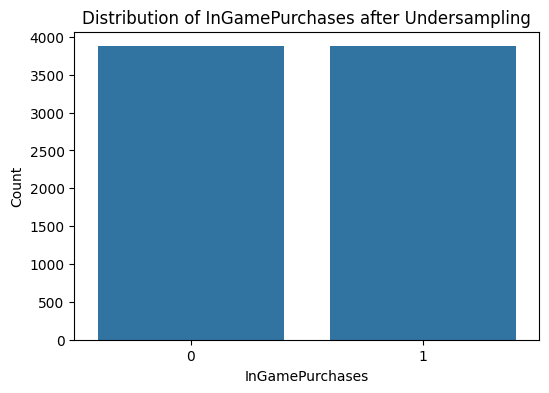

In [23]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of InGamePurchases after Undersampling')
plt.xlabel('InGamePurchases')
plt.ylabel('Count')
plt.show()
